# Single species single end library

In [110]:
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import skbio
import skbio.diversity

In [2]:
plt.style.use('seaborn')
%matplotlib inline

### Dataset

CONFIGURATION (edit the following cell)

In [3]:
raw_reads_path = '/Users/laserson/Downloads/BaseSpace/Metagenomiclibraries-39688650/3-48085070/bovatus500wopselect_S3_L001_R1_001.fastq.gz'
analysis_dir_path = '/Users/laserson/tmp/phip_analysis/phip-7/phip-7-single'
sample_prefix = 'bovatus500wopselect_S3_L001_R1_001'

In [97]:
vector_depleted_reads_path = pjoin(analysis_dir_path, 'vector_depleted', sample_prefix + '.fastq')
species_aligned_bam_path = pjoin(analysis_dir_path, 'species_aligned', sample_prefix + '.bam')
genome_cov_path = pjoin(analysis_dir_path, 'coverage', sample_prefix + '.cov_genome.tsv')
gene_cov_path = pjoin(analysis_dir_path, 'coverage', sample_prefix + '.cov_stranded.tsv')
inframe_cov_path = pjoin(analysis_dir_path, 'coverage', sample_prefix + '.cov_inframe.tsv')
clustered_read_counts_path = pjoin(analysis_dir_path, 'clustered_reads', sample_prefix + '.clustered.counts.tsv')
inframe_insert_counts_path = pjoin(analysis_dir_path, 'annot', sample_prefix + '.inframe_inserts.counts.tsv')
recon_allreads_path = pjoin(analysis_dir_path, 'diversity', sample_prefix + '.recon_allreads.txt')
recon_inframe_path = pjoin(analysis_dir_path, 'diversity', sample_prefix + '.recon_inframe.txt')

## Statistics

Number of raw reads

In [5]:
_ = !cat {raw_reads_path} | gunzip | wc -l
raw_read_count = int(_[0]) // 4
raw_read_count

7967079

Number of non-vector reads

In [6]:
_ = !cat {vector_depleted_reads_path} | wc -l
non_vector_read_count = int(_[0]) // 4
non_vector_read_count

5374985

Fraction non-vector reads

In [7]:
non_vector_read_count / raw_read_count

0.6746493915775155

Number of species-aligned reads

In [8]:
_ = !samtools view -c -F 4 {species_aligned_bam_path}
aligned_read_count = int(_[0])
aligned_read_count

2423071

Fraction of non-vector reads that map to species

In [9]:
aligned_read_count / non_vector_read_count

0.4508051650376699

Fraction of all reads that map to species

In [10]:
aligned_read_count / raw_read_count

0.30413543031266543

## Coverage

**Genome Coverage**

In [12]:
genome_cov = pd.read_csv(genome_cov_path, sep='\t', header=None, names=['chr', 'pos', 'cov'])

Number of bases of genome covered

In [13]:
(genome_cov['cov'] > 0).sum()

2515185

Fraction of genome covered

In [14]:
(genome_cov['cov'] > 0).sum() / len(genome_cov)

0.38859625717401758

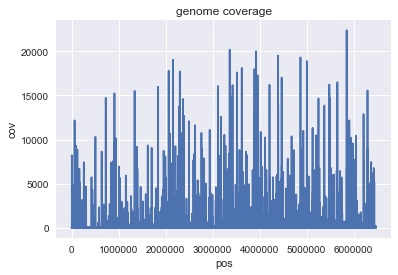

In [15]:
fig, ax = plt.subplots()
ax.plot(genome_cov['pos'], genome_cov['cov'])
ax.set(title='genome coverage', xlabel='pos', ylabel='cov')

[None,

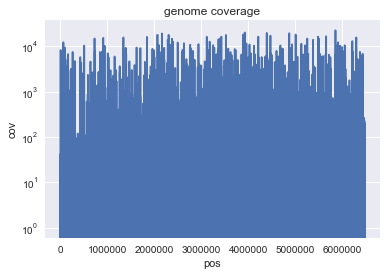

In [16]:
fig, ax = plt.subplots()
ax.plot(genome_cov['pos'], genome_cov['cov'])
ax.set(title='genome coverage', xlabel='pos', ylabel='cov', yscale='log')

[<matplotlib.text.Text at 0x116de6278>, <matplotlib.text.Text at 0x11e6b03c8>]

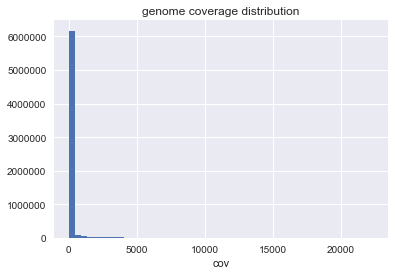

In [17]:
fig, ax = plt.subplots()
ax.hist(genome_cov['cov'], bins=50)
ax.set(title='genome coverage distribution', xlabel='cov')

[<matplotlib.text.Text at 0x11e9f17b8>, <matplotlib.text.Text at 0x11ea9cb70>]

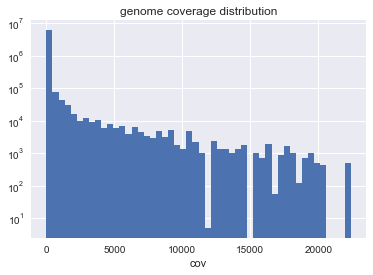

In [18]:
fig, ax = plt.subplots()
ax.hist(genome_cov['cov'], bins=50, log=True)
ax.set(title='genome coverage distribution', xlabel='cov')

[(0, 1),
 None,
 (1.0, 22371.0),

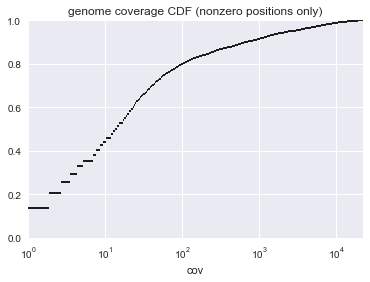

In [81]:
nonzero = genome_cov['cov'] > 0
hist, bin_edges = np.histogram(genome_cov['cov'][nonzero], bins='auto')
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='genome coverage CDF (nonzero positions only)', xlabel='cov', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1], xscale='log')

In [42]:
pct90 = sp.stats.scoreatpercentile(genome_cov['cov'][nonzero], 90)
pct80 = sp.stats.scoreatpercentile(genome_cov['cov'][nonzero], 80)
pct20 = sp.stats.scoreatpercentile(genome_cov['cov'][nonzero], 20)
pct10 = sp.stats.scoreatpercentile(genome_cov['cov'][nonzero], 10)

Percentiles

In [43]:
pct10, pct20, pct80, pct90

(1.0, 2.0, 103.0, 686.0)

Cover middle 80% of unique clones with how many logs of frequency?

In [45]:
np.log10(pct90) - np.log10(pct10)

2.8363241157067516

Cover middle 60% of unique clones with how many logs of frequency?

In [46]:
np.log10(pct80) - np.log10(pct20)

1.7118072290411908

**ORF Coverage**

In [20]:
names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'num_reads', 'num_cov_bases', 'len', 'frac_bases_cov']
gene_cov = pd.read_csv(gene_cov_path, sep='\t', header=None, names=names)

Number of genes

In [21]:
len(gene_cov)

4996

Number of covered genes

In [22]:
np.sum(gene_cov['num_cov_bases'] > 0)

2805

Fraction genes covered

In [23]:
np.sum(gene_cov['num_cov_bases'] > 0) / len(gene_cov)

0.56144915932746198

Fraction coding bases covered

In [24]:
gene_cov['num_cov_bases'].sum() / gene_cov['len'].sum()

0.24869734503296492

Distribution of gene coverage fractions

For each gene, compute histogram of its coverage fraction.  Only compute over genes that have non-zero coverage.

[<matplotlib.text.Text at 0x11eceff98>, <matplotlib.text.Text at 0x11c684080>]

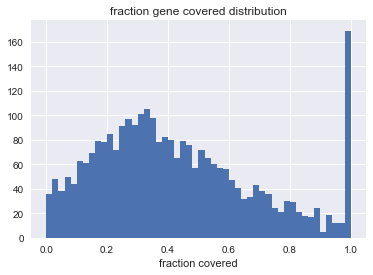

In [25]:
fig, ax = plt.subplots()
ax.hist(gene_cov.loc[gene_cov['frac_bases_cov'] > 0]['frac_bases_cov'], bins=50)
ax.set(title='fraction gene covered distribution', xlabel='fraction covered')

Distribution of number of reads that overlaps each gene

[<matplotlib.text.Text at 0x122ddc0b8>, <matplotlib.text.Text at 0x122fba780>]

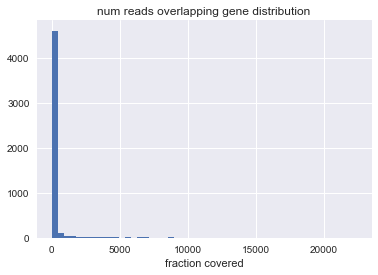

In [64]:
fig, ax = plt.subplots()
ax.hist(gene_cov['num_reads'], bins=50)
ax.set(title='num reads overlapping gene distribution', xlabel='fraction covered')

[<matplotlib.text.Text at 0x12308ca20>, <matplotlib.text.Text at 0x122dc4a90>]

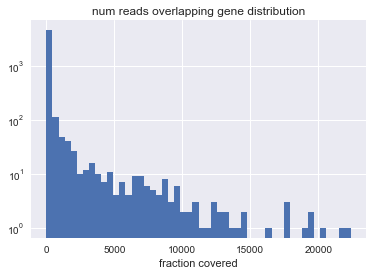

In [65]:
fig, ax = plt.subplots()
ax.hist(gene_cov['num_reads'], bins=50, log=True)
ax.set(title='num reads overlapping gene distribution', xlabel='fraction covered')

[(0, 1),
 None,
 (1.0, 22382.0),

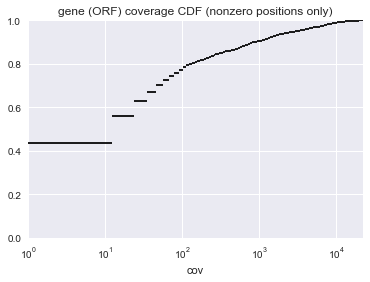

In [85]:
nonzero = gene_cov['num_reads'] > 0
hist, bin_edges = np.histogram(gene_cov['num_reads'][nonzero], bins='auto')
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='gene (ORF) coverage CDF (nonzero positions only)', xlabel='cov', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1], xscale='log')

**Inframe Coverage**

Fraction of ORFs that have inframe clones

In [98]:
names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'num_reads', 'num_cov_bases', 'len', 'frac_bases_cov']
inframe_cov = pd.read_csv(inframe_cov_path, sep='\t', header=None, names=names)

Number of covered genes

In [100]:
np.sum(inframe_cov['num_cov_bases'] > 0)

1628

Fraction genes covered

In [101]:
np.sum(inframe_cov['num_cov_bases'] > 0) / len(inframe_cov)

0.32586068855084066

Fraction coding bases covered

In [102]:
inframe_cov['num_cov_bases'].sum() / inframe_cov['len'].sum()

0.1095057228036649

Distribution of gene coverage fractions

For each gene, compute histogram of its coverage fraction.  Only compute over genes that have non-zero coverage.

[<matplotlib.text.Text at 0x121f3e8d0>, <matplotlib.text.Text at 0x120383fd0>]

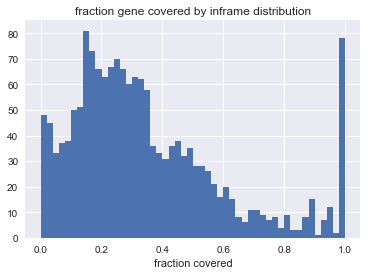

In [104]:
fig, ax = plt.subplots()
ax.hist(inframe_cov.loc[inframe_cov['frac_bases_cov'] > 0]['frac_bases_cov'], bins=50)
ax.set(title='fraction gene covered by inframe distribution', xlabel='fraction covered')

Distribution of number of reads that overlaps each gene

[<matplotlib.text.Text at 0x1203da8d0>, <matplotlib.text.Text at 0x1220dc518>]

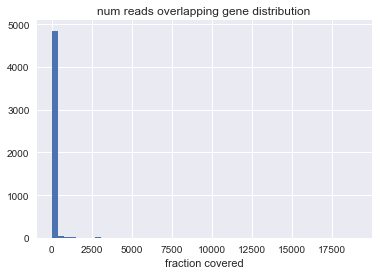

In [105]:
fig, ax = plt.subplots()
ax.hist(inframe_cov['num_reads'], bins=50)
ax.set(title='num reads overlapping gene distribution', xlabel='fraction covered')

[<matplotlib.text.Text at 0x1272f8160>, <matplotlib.text.Text at 0x1274ab198>]

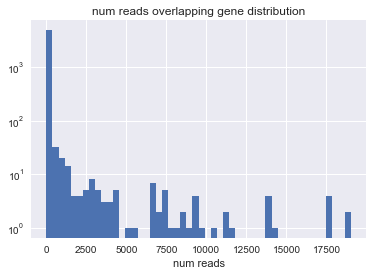

In [109]:
fig, ax = plt.subplots()
ax.hist(inframe_cov['num_reads'], bins=50, log=True)
ax.set(title='num reads overlapping gene distribution', xlabel='num reads')

[(0, 1),
 None,
 (1.0, 19013.0),

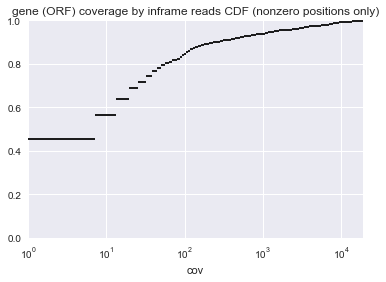

In [108]:
nonzero = inframe_cov['num_reads'] > 0
hist, bin_edges = np.histogram(inframe_cov['num_reads'][nonzero], bins='auto')
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='gene (ORF) coverage by inframe reads CDF (nonzero positions only)', xlabel='cov', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1], xscale='log')

## Diversity

In [26]:
clustered_read_counts = pd.read_csv(clustered_read_counts_path, sep='\t', header=None, usecols=[0]).values.ravel()
inframe_insert_counts = pd.read_csv(inframe_insert_counts_path, sep='\t', header=None, usecols=[1]).values.ravel()

**Observed**

In [27]:
len(clustered_read_counts)

42364

In [28]:
len(inframe_insert_counts)

1838

**Chao1**

In [29]:
skbio.diversity.alpha_diversity('chao1', clustered_read_counts)[0]

179895.49657534246

In [30]:
skbio.diversity.alpha_diversity('chao1', inframe_insert_counts)[0]

2387.3886255924172

**Shannon entropy effective population size**

In [59]:
2 ** skbio.diversity.alpha_diversity('shannon', clustered_read_counts)[0]

1255.7034826896977

In [58]:
2 ** skbio.diversity.alpha_diversity('shannon', inframe_insert_counts)[0]

102.81563707872104

**Recon**

In [31]:
def parse_recon_fitfile(path):
    with open(path, 'r') as ip:
        lines = [line.strip() for line in ip.readlines()]
    lines.reverse()
    line = lines.pop()
    while not line.startswith('observed_clone_size_distribution'):
        line = lines.pop()
    observed_clone_size_distribution = eval(line.split('=')[-1])
    start = lines.index('===========================================')
    n0 = float(lines[start + 4].split('=')[-1].strip())
    parameters = eval(lines[start + 5].split('=')[-1])
    weights = parameters[:len(parameters) // 2]
    means = parameters[len(parameters) // 2:]
    return {'observed_clone_size_distribution': observed_clone_size_distribution,
            'n0': n0,
            'weights': weights,
            'means': means}

In [1]:
# recon_allreads_results = parse_recon_fitfile(recon_allreads_path)

In [2]:
# sum(recon_allreads_results['observed_clone_size_distribution'].values())

**Distribution of inframe clones**

[<matplotlib.text.Text at 0x11f94edd8>, <matplotlib.text.Text at 0x11f4be208>]

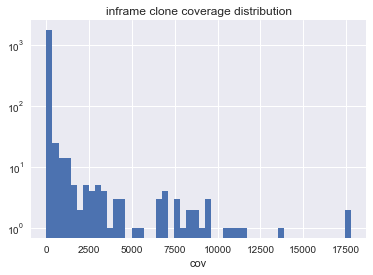

In [83]:
fig, ax = plt.subplots()
ax.hist(inframe_insert_counts, bins=50, log=True)
ax.set(title='inframe clone coverage distribution', xlabel='cov')

[(0, 1),
 None,
 (1.0, 17768.0),

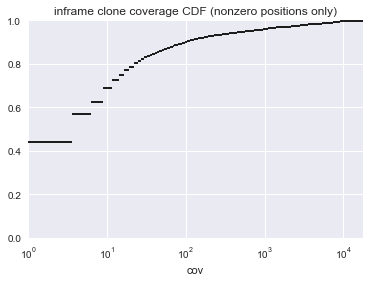

In [84]:
hist, bin_edges = np.histogram(inframe_insert_counts, bins='auto')
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='inframe clone coverage CDF (nonzero positions only)', xlabel='cov', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1], xscale='log')

In [54]:
pct90 = sp.stats.scoreatpercentile(inframe_insert_counts, 90)
pct80 = sp.stats.scoreatpercentile(inframe_insert_counts, 80)
pct20 = sp.stats.scoreatpercentile(inframe_insert_counts, 20)
pct10 = sp.stats.scoreatpercentile(inframe_insert_counts, 10)

In [55]:
pct10, pct20, pct80, pct90

(1.0, 1.0, 24.0, 100.0)

**"Useful" particles/clones**

In [87]:
num_inframe_clones = len(inframe_insert_counts)
num_inframe_clones

1838

In [89]:
num_inframe_particles = inframe_insert_counts.sum()
num_inframe_particles

416152

In [90]:
num_nonvector_clones = len(clustered_read_counts)
num_nonvector_clones

42364

In [91]:
num_nonvector_particles = clustered_read_counts.sum()
num_nonvector_particles

5374985

In [92]:
num_total_particles = raw_read_count
num_total_particles

7967079

Fraction clones "useful" (of non-vector clones)

In [93]:
num_inframe_clones / num_nonvector_clones

0.043385893683316024

Fraction particles "useful" (of non-vector particles)

In [94]:
num_inframe_particles / num_nonvector_particles

0.077423843973518064

Fraction particles "useful" (of *all* particles, including vector-coding)

In [95]:
num_inframe_particles / num_total_particles

0.052233949230326447